Preprocessing...
Initial dataset sizes:
Dataset 'MacBookPro1' before preprocessing: 1000
Dataset 'MacBookPro2' before preprocessing: 1000
Dataset 'RaspberryPi' before preprocessing: 1000
Dataset 'VM' before preprocessing: 1000

Dataset types: Execution Time            float64
Hour                        int32
DayOfWeek                   int32
ServerType_MacBookPro1       bool
ServerType_MacBookPro2       bool
ServerType_RaspberryPi       bool
ServerType_VM                bool
dtype: object

Dataset duplicat rows before: 33

Dataset duplicat rows after: 0

Dataset after preprocessing checking for outliers via IQR method, missing value impute with median and combine datasets:  3934

Testing with test size: 0.1
Linear Regression - MSE: 0.004951454528228592, R-squared: 0.9592181797199524
Random Forest Regressor - MSE: 0.004941672834274181, R-squared: 0.9592987449927645
Ridge Regression - MSE: 0.004949977333017889, R-squared: 0.9592303463892125

Testing with test size: 0.2
Linear Regression

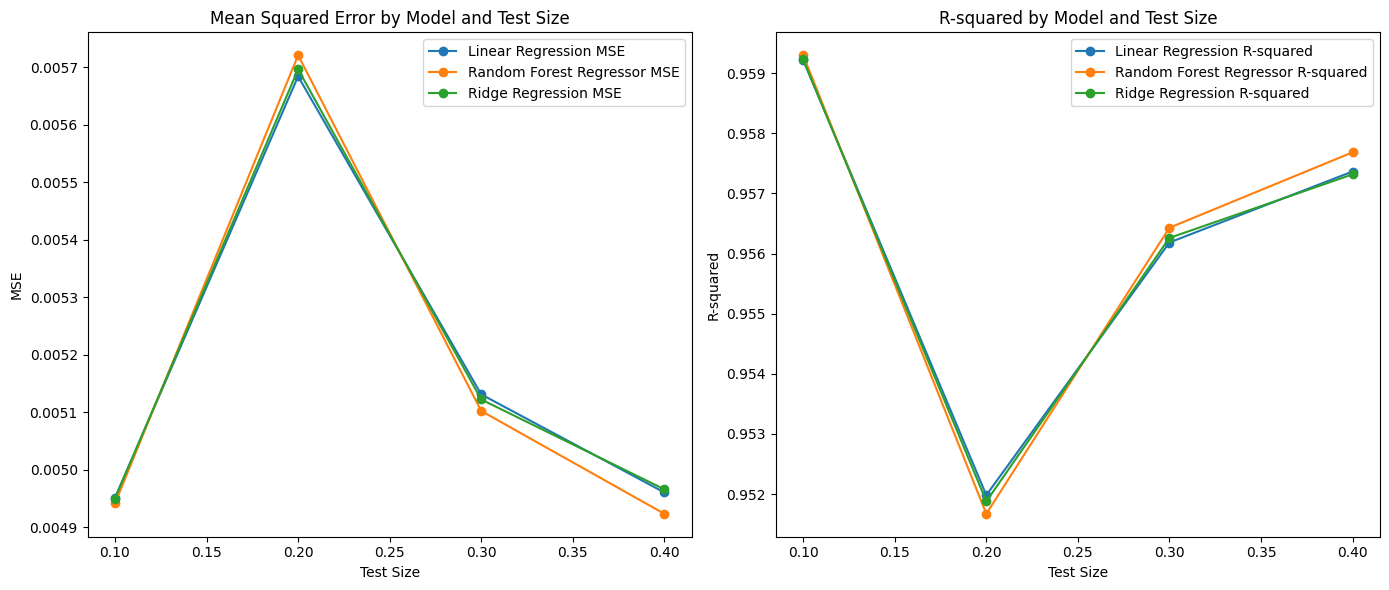

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Load the datasets
df_macbook_pro1 = pd.read_csv('../datasets/MacBookPro1.csv')
df_macbook_pro2 = pd.read_csv('../datasets/MacBookPro2.csv')
df_raspberry_pi = pd.read_csv('../datasets/RaspberryPi.csv')
df_vm = pd.read_csv('../datasets/VM.csv')

# Pre-processing steps
datasets = [df_macbook_pro1, df_macbook_pro2, df_raspberry_pi, df_vm]
server_names = ['MacBookPro1', 'MacBookPro2', 'RaspberryPi', 'VM']

print("Preprocessing...")
print("Initial dataset sizes:")
for df, name in zip(datasets, server_names):
    print(f"Dataset '{name}' before preprocessing: {len(df)}")

for i, df in enumerate(datasets):
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
    numeric_imputer = SimpleImputer(strategy='median')
    categorical_imputer = SimpleImputer(strategy="most_frequent")

    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col].dtype):
            df[col] = numeric_imputer.fit_transform(df[[col]])
        elif pd.api.types.is_object_dtype(df[col].dtype):
            df[col] = categorical_imputer.fit_transform(df[[col]])

    df['Hour'] = df['Time'].dt.hour
    df['DayOfWeek'] = df['Time'].dt.dayofweek
    df['ServerType'] = server_names[i]

df_combined = pd.concat(datasets).reset_index(drop=True)
df_combined = pd.get_dummies(df_combined, columns=['ServerType'])
df_combined.drop('Time', axis=1, inplace=True)

print("")
print("Dataset types:", df_combined.dtypes)
print("")
print("Dataset duplicat rows before:", df_combined.duplicated().sum())
df_combined.drop_duplicates(keep= False, inplace= True)
print("")
print("Dataset duplicat rows after:", df_combined.duplicated().sum())
print("")
print("Dataset after preprocessing checking for outliers via IQR method, missing value impute with median and combine datasets: ", len(df_combined))

final_imputer = SimpleImputer(strategy='median')
df_combined = pd.DataFrame(final_imputer.fit_transform(df_combined), columns=df_combined.columns)

X = df_combined.drop(['Execution Time'], axis=1)
y = df_combined['Execution Time']

split_ratios = [0.1, 0.2, 0.3, 0.4]
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'Ridge Regression': Ridge(alpha=1.0)
}

# Prepare data for plotting
mse_results = {name: [] for name in models.keys()}
r2_results = {name: [] for name in models.keys()}

# Testing different train-test splits
for test_size in split_ratios:
    print("\nTesting with test size:", test_size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mse_results[name].append(mse)
        r2_results[name].append(r2)
        print(f"{name} - MSE: {mse}, R-squared: {r2}")

# Plotting the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
for name in models:
    ax1.plot(split_ratios, mse_results[name], marker='o', label=f'{name} MSE')
    ax2.plot(split_ratios, r2_results[name], marker='o', label=f'{name} R-squared')

ax1.set_title('Mean Squared Error by Model and Test Size')
ax1.set_xlabel('Test Size')
ax1.set_ylabel('MSE')
ax1.legend()

ax2.set_title('R-squared by Model and Test Size')
ax2.set_xlabel('Test Size')
ax2.set_ylabel('R-squared')
ax2.legend()

plt.tight_layout()
plt.show()
